# Entity Matching using Neo4j - Entropy

_Salomon Tetelepta, May 12th 2024_
* See if we can detect model identifiers using entropy

### Install dependencies

In [1]:
!pip install neo4j python-dotenv langchain-community --quiet

%load_ext watermark
%watermark -p neo4j

neo4j: 5.17.0



### Imports

In [2]:
from dotenv import load_dotenv, find_dotenv, dotenv_values
from langchain_community.graphs import Neo4jGraph
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from wordfreq import lossy_tokenize, tokenize, word_frequency

import json
import matplotlib.pyplot as plt
import neo4j
import numpy as np

import os
import pandas as pd
import pickle
import re

### Settings

In [3]:
# path settings
project_path = Path(os.getcwd()).parent
data_path = project_path / "data"
output_path = project_path / "output"

database = "abt-buy"

# load env settings
load_dotenv(project_path / ".env")

# reproducability
np.random.seed(42)

### Helper functions

### 1. Load Data

In [4]:
os.listdir(data_path / 'abt-buy' / 'record_descriptions')

['2_buy.csv', '1_abt.csv']

In [5]:
# abt and buy records
df_abt = pd.read_csv(data_path / 'abt-buy' / 'record_descriptions' / '1_abt.csv', encoding='unicode_escape')
df_buy = pd.read_csv(data_path / 'abt-buy' / 'record_descriptions' / '2_buy.csv')

# matches - train and validation set
df_train = pd.read_csv(data_path / 'abt-buy' / 'gs_train.csv')
df_val = pd.read_csv(data_path / 'abt-buy' / 'gs_val.csv')
df_test = pd.read_csv(data_path / 'abt-buy' / 'gs_test.csv')

# merge records with matches
df_abt_merged = df_abt.merge(df_train, left_on='subject_id', right_on='source_id', how='right')
df_train_merged = df_buy.merge(df_abt_merged, left_on='subject_id', right_on='target_id', how='right')

df_train_merged.head(3)

,subject_id_x,name_x,description_x,manufacturer,price_x,subject_id_y,name_y,description_y,price_y,source_id,target_id,matching
0,207390654,Sony Handycam HDR-SR10 High Definition Digital...,16:9 - 2.7' Hybrid LCD,Sony,549.0,33161,Sony High Definition HDV Handycam Camcorder - ...,Sony High Definition HDV Handycam Camcorder - ...,NaN,33161,207390654,False
1,208085180,Pioneer DEH-2000MP Car Audio Player,"CD-RW - CD-Text, MP3, WMA, WAV - LCD - 4 - 200...",Pioneer,84.0,36258,D-Link Broadband Cable Modem - DCM202,D-Link Broadband Cable Modem - DCM202/ DOCSIS ...,79.00,36258,208085180,False
2,90125786,Sanus Wall/Ceiling Speaker Mount - WMS3S SILVER,Plastic - 8 lb,Sanus,NaN,17417,Sanus 13' - 30' VisionMount Flat Panel TV Silv...,Sanus 13' - 30' VisionMount Flat Panel TV Silv...,39.99,17417,90125786,False


### Connect to Neo4j

In [6]:
# connect to Neo4j
graph = Neo4jGraph(
    url=os.getenv('NEO4J_URL'),
    username=os.getenv('NEO4J_USER'),
    password=os.getenv('NEO4J_PASS')
)

# create database if does not exist
graph._database = "system"
query = f"CREATE DATABASE `{database}` IF NOT EXISTS"
graph.query(query)

# change to target database
graph._database = database
print("database:", graph._database)

# check nr nodes in the graph
graph.query("MATCH (n) RETURN count(n)")

database: abt-buy


[{'count(n)': 612891}]

### Read ngrams

In [269]:
df_ngrams = pd.read_csv(output_path / "ngrams.csv").dropna()
df_ngrams['sum'] = df_ngrams.groupby('n')['count'].transform('sum')
df_ngrams['p'] = np.round(df_ngrams['count'] / df_ngrams['sum'], 6)
df_ngrams

,ngram,count,n,sum,p
0,e,235878,1,2261675,0.104293
1,i,201328,1,2261675,0.089017
2,a,199893,1,2261675,0.088383
3,o,171025,1,2261675,0.075619
4,r,161328,1,2261675,0.071331
...,...,...,...,...,...
545971,rleuco,1,6,1087272,0.000001
545972,erlipe,1,6,1087272,0.000001
545973,rlipem,1,6,1087272,0.000001
545974,erlipo,1,6,1087272,0.000001


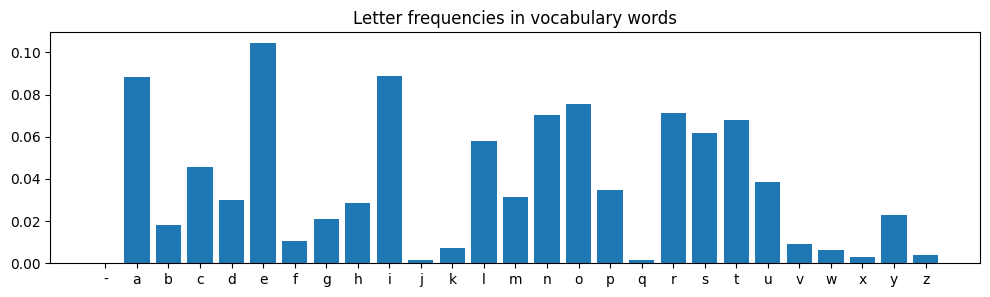

In [270]:
n = 1
cond_ngram = df_ngrams.n == n
df_plot = df_ngrams[cond_ngram].sort_values('ngram')

plt.figure(figsize=(12, 3))
plt.title("Letter frequencies in vocabulary words")
plt.bar(df_plot['ngram'], df_plot['p'])
plt.show()

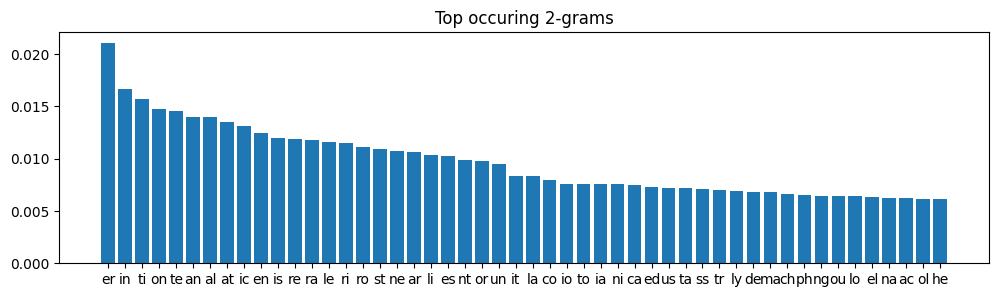

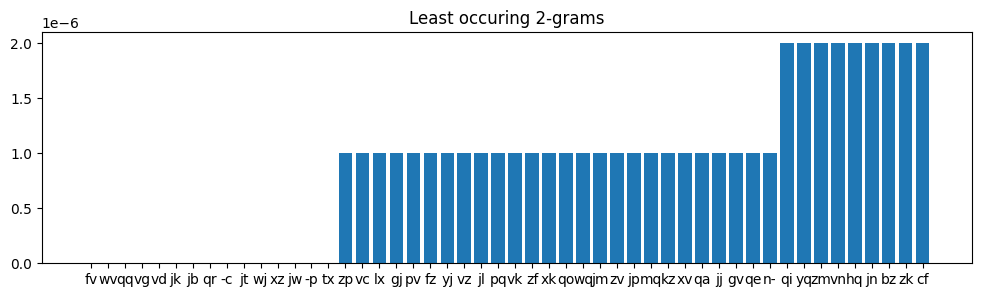

In [271]:
n = 2
cond_ngram = df_ngrams.n == n
df_plot = df_ngrams[cond_ngram].sort_values('p', ascending=False).head(50)

plt.figure(figsize=(12, 3))
plt.title("Top occuring 2-grams")
plt.bar(df_plot['ngram'], df_plot['p'])
plt.show()

df_plot = df_ngrams[cond_ngram].sort_values('p', ascending=True).head(50)
plt.figure(figsize=(12, 3))
plt.title("Least occuring 2-grams")
plt.bar(df_plot['ngram'], df_plot['p'])
plt.show()

### Entropy of a word

In [272]:
from scipy.stats import entropy
from itertools import islice, tee

In [273]:
def get_probabilities(df_ngrams, n=1):
    cond_ngram = df_ngrams.n == n
    return df_ngrams[cond_ngram].set_index('ngram')['p'].to_dict()

probs = get_probabilities(df_ngrams, n=1)

In [274]:
def get_ngrams(s, n):
    ngrams = list(zip(*(islice(seq, index, None) for index, seq in enumerate(tee(s, n)))))
    return ["".join(n) for n in ngrams]

In [275]:
get_ngrams("apple", 1)

['a', 'p', 'p', 'l', 'e']

In [277]:
query = "MATCH (w:WordLower) RETURN w.value AS value"
results = graph.query(query)
df_results = pd.DataFrame(results)
df_results.head()

,value
0,sony
1,turntable
2,-
3,pslx350h
4,pslx350h/


In [267]:
%%time
output = []
n = 3
probs = get_probabilities(df_ngrams, n=n) 
for idx, row in df_results.iterrows():
    word = row['value']
    #word = ''.join([i for i in row['value'] if not i.isdigit()])
    word = re.sub('[^A-Za-z]+', ' ', word)
    ngrams = get_ngrams(word, n)
    pk = [probs.get(ngram.lower(), 0) for ngram in ngrams]
    median_p = np.median(pk)
    mean_p = np.mean(pk)
    H = entropy(pk, base=2)
    output.append({'value': row['value'], 'word': word, 'median_p': median_p, 'mean_p': mean_p, 'entropy': H})

/Users/stetelepta/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/stetelepta/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/stetelepta/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


CPU times: user 462 ms, sys: 22.6 ms, total: 484 ms
Wall time: 473 ms


In [278]:
df_results = pd.DataFrame(output)
df_results[df_results['mean_p'] > 0.0000001].sort_values('mean_p', ascending=True).head(50)

,value,word,median_p,mean_p,entropy
3892,ts4gsdhc6,ts gsdhc,0.0,1.428571e-07,0.0
7234,vgncs180jr/,vgncs jr,0.0,1.428571e-07,0.0
7232,vgncs180jq/,vgncs jq,0.0,1.428571e-07,0.0
9532,vgncs110e/r,vgncs e r,0.0,1.428571e-07,0.0
7227,vgncs180jp/,vgncs jp,0.0,1.428571e-07,0.0
7214,vgncs110er/,vgncs er,0.0,1.428571e-07,0.0
9618,vgncs180j/w,vgncs j w,0.0,1.428571e-07,0.0
9620,vgncs180j/q,vgncs j q,0.0,1.428571e-07,0.0
9623,vgncs180j/p,vgncs j p,0.0,1.428571e-07,0.0
9626,vgncs180j/r,vgncs j r,0.0,1.428571e-07,0.0


In [279]:
lines = """pear
applejuice
apple
DRFT056
qrtzq
aB1#h%p*Mx
#xq(ptws%m~fj'&k.v-d"!hr[y
f4Cj7FNd|]p_#6DB0)Q;:-aZ98ni&y'q"""

probs = get_probabilities(df_ngrams, n=2) 
for word in lines.split("\n"):
    ngrams = get_ngrams(word, 2)
    
    pk = [probs.get(ngram.lower(), 0) for ngram in ngrams]
    median_p = np.median(pk)
    mean_p = np.mean(pk)
    H = entropy(pk, base=2)
    print(word, ngrams)
    print("median_p:", median_p)
    print("mean_p:", mean_p)
    
    #print(H)
    print()

pear ['pe', 'ea', 'ar']
median_p: 0.005553
mean_p: 0.007057000000000001

applejuice ['ap', 'pp', 'pl', 'le', 'ej', 'ju', 'ui', 'ic', 'ce']
median_p: 0.002464
mean_p: 0.004304777777777778

apple ['ap', 'pp', 'pl', 'le']
median_p: 0.0030155
mean_p: 0.0046465000000000005

DRFT056 ['DR', 'RF', 'FT', 'T0', '05', '56']
median_p: 0.0002005
mean_p: 0.00042866666666666666

qrtzq ['qr', 'rt', 'tz', 'zq']
median_p: 3.55e-05
mean_p: 0.000721

aB1#h%p*Mx ['aB', 'B1', '1#', '#h', 'h%', '%p', 'p*', '*M', 'Mx']
median_p: 0.0
mean_p: 0.0004983333333333334

#xq(ptws%m~fj'&k.v-d"!hr[y ['#x', 'xq', 'q(', '(p', 'pt', 'tw', 'ws', 's%', '%m', 'm~', '~f', 'fj', "j'", "'&", '&k', 'k.', '.v', 'v-', '-d', 'd"', '"!', '!h', 'hr', 'r[', '[y']
median_p: 0.0
mean_p: 0.00014472

f4Cj7FNd|]p_#6DB0)Q;:-aZ98ni&y'q ['f4', '4C', 'Cj', 'j7', '7F', 'FN', 'Nd', 'd|', '|]', ']p', 'p_', '_#', '#6', '6D', 'DB', 'B0', '0)', ')Q', 'Q;', ';:', ':-', '-a', 'aZ', 'Z9', '98', '8n', 'ni', 'i&', '&y', "y'", "'q"]
median_p: 0.0
mean_p: 